### Introdução

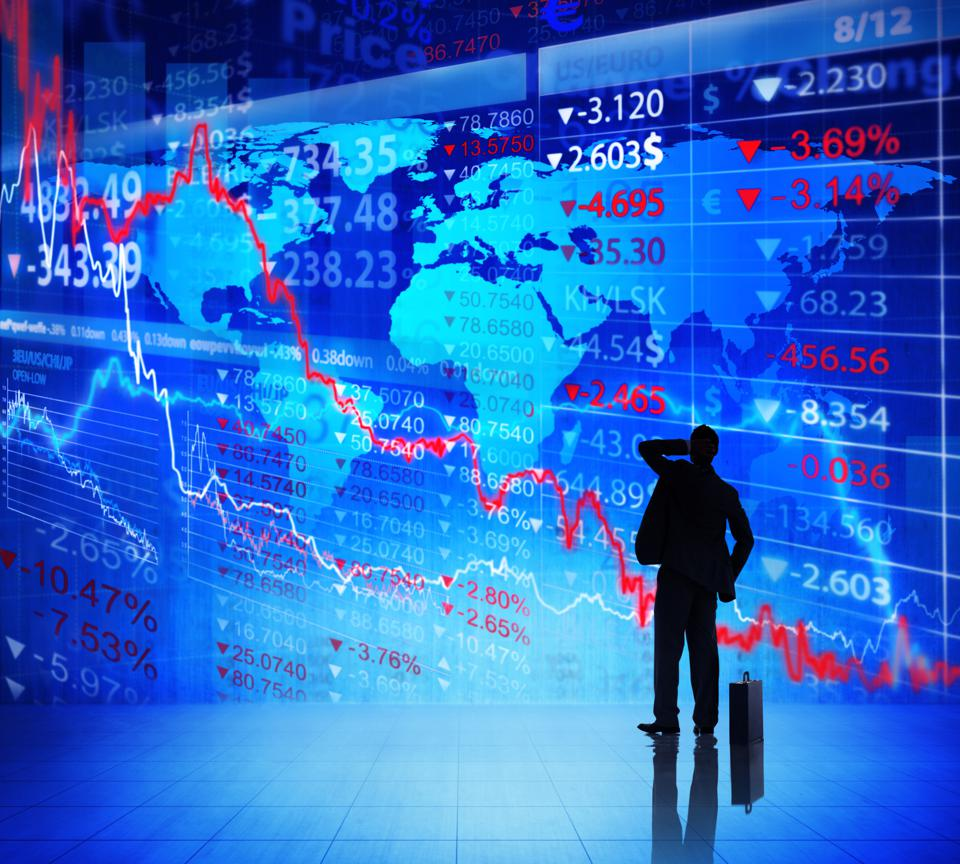

O objetivo deste kernel é identificar a tendência no preço futuro das ações do Itaú com base nos dados dos anos anteriores.

Temos dados históricos das ações do Itaú dos anos 2000 até o presente. Usaremos todo o dado histórico na criação do modelo, mas usando apenas uma janela de 60 dias para prever o preço da ação no dia seguinte. Em seguida, compararemos o quão próximas nossas previsões estão os verdadeiros valores. Nosso modelo é capaz de prever os 'bull market' e 'bear market' com precisão? Nosso modelo vai gerar lucro?

Então vamos começar.

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import seaborn as sns
import yfinance as yf

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler 

import pylab

c:\Users\Leonardo\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
plt.rcParams["figure.figsize"] = (7.5,5)
plt.style.use('seaborn')

pylab.rc('figure', figsize=(10,7))

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=BIGGER_SIZE)         
plt.rc('axes', titlesize=BIGGER_SIZE)  
plt.rc('axes', labelsize=BIGGER_SIZE)  
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)  
plt.rc('legend', fontsize=MEDIUM_SIZE)  
plt.rc('figure', titlesize=BIGGER_SIZE)  

### Carregando dados via API

In [3]:
stock_past = yf.download("ITUB4.SA", end="2021-12-31")

stock_past.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-23,21.330000,21.570000,21.170000,21.340000,20.492579,22377000
2021-12-27,21.480000,21.700001,21.309999,21.559999,20.703844,14025800
2021-12-28,21.629999,21.700001,21.400000,21.480000,20.627018,15294200
2021-12-29,21.530001,21.580000,21.230000,21.299999,20.454166,12856100
2021-12-30,21.440001,21.440001,20.950001,20.950001,20.118067,39997300


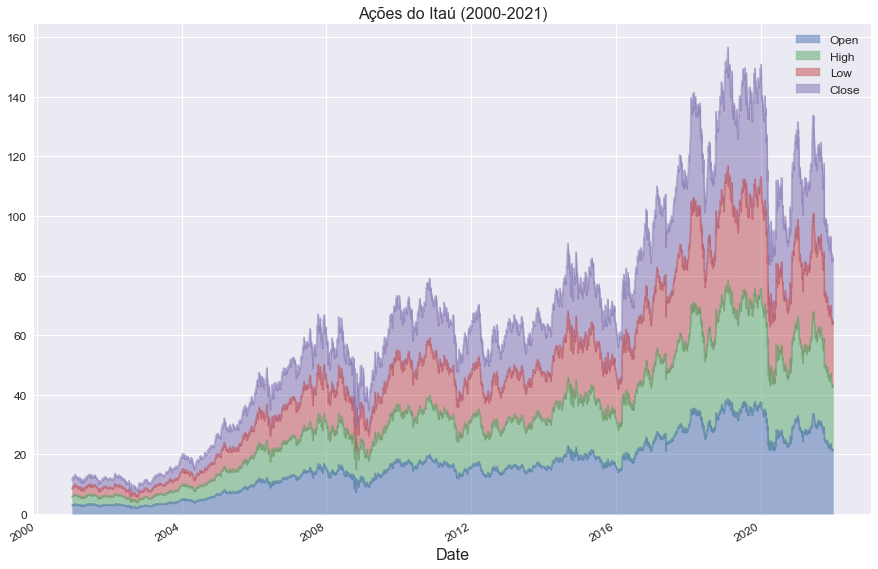

In [4]:
stock_past[["Open","High","Low","Close"]].plot.area(figsize=(15,10),alpha=0.5);
plt.title('Ações do Itaú (2000-2021)')
plt.show()

Vamos focar agora no histórico apenas de abertura de preço.

In [5]:
stock=stock_past["Open"]

In [6]:
##Agrupando dados por ano
groups=stock.groupby(pd.Grouper(freq='A'))

years={}
for name, group in groups:
    years[name.year] = group.values
    
years=pd.DataFrame.from_dict(years, orient='index')

years=years.transpose()

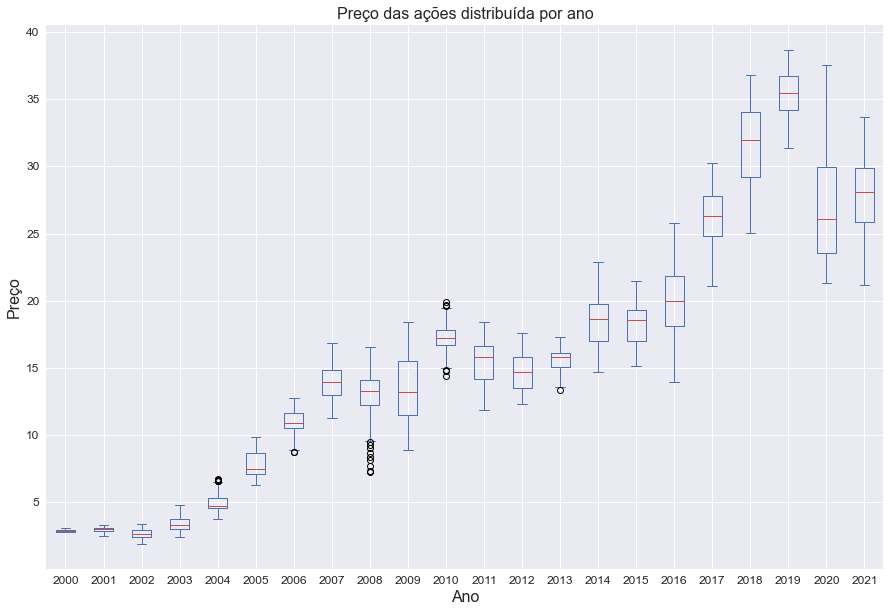

In [7]:
years.plot.box(figsize=(15,10))
plt.title('Preço das ações distribuída por ano')
plt.ylabel('Preço')
plt.xlabel('Ano')
plt.show()

c:\Users\Leonardo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


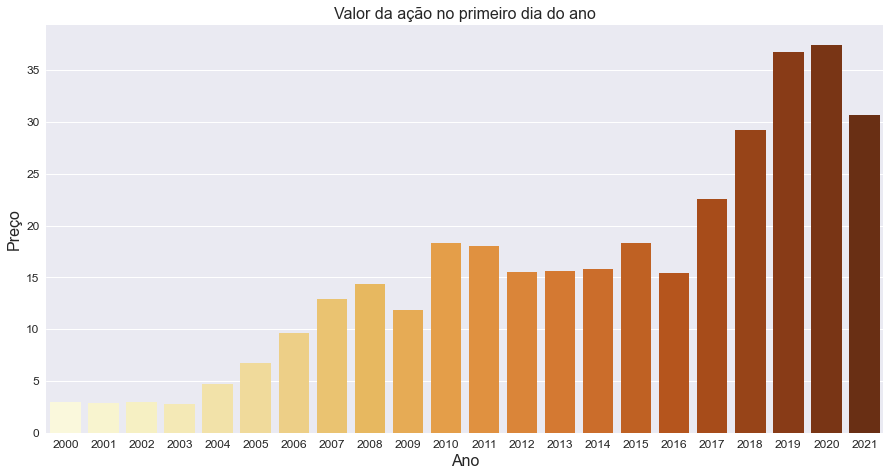

In [8]:
plt.figure(figsize=(15,7.5))
sns.barplot(years.iloc[1,:].index,years.iloc[1,:].values,palette='YlOrBr')
plt.title('Valor da ação no primeiro dia do ano')
plt.ylabel('Preço')
plt.xlabel('Ano')
plt.show()

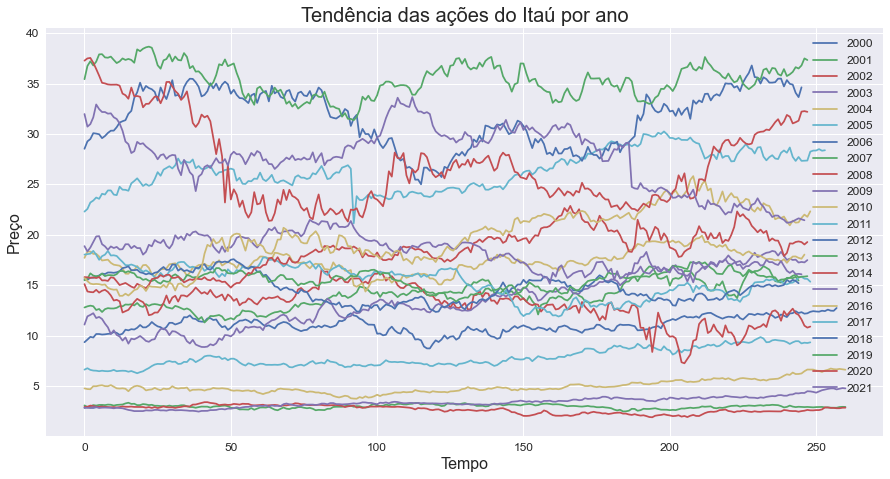

In [9]:
years.plot(figsize=(15,7.5))
plt.title('Tendência das ações do Itaú por ano',fontsize=20)
plt.ylabel('Preço')
plt.xlabel('Tempo')
plt.show()

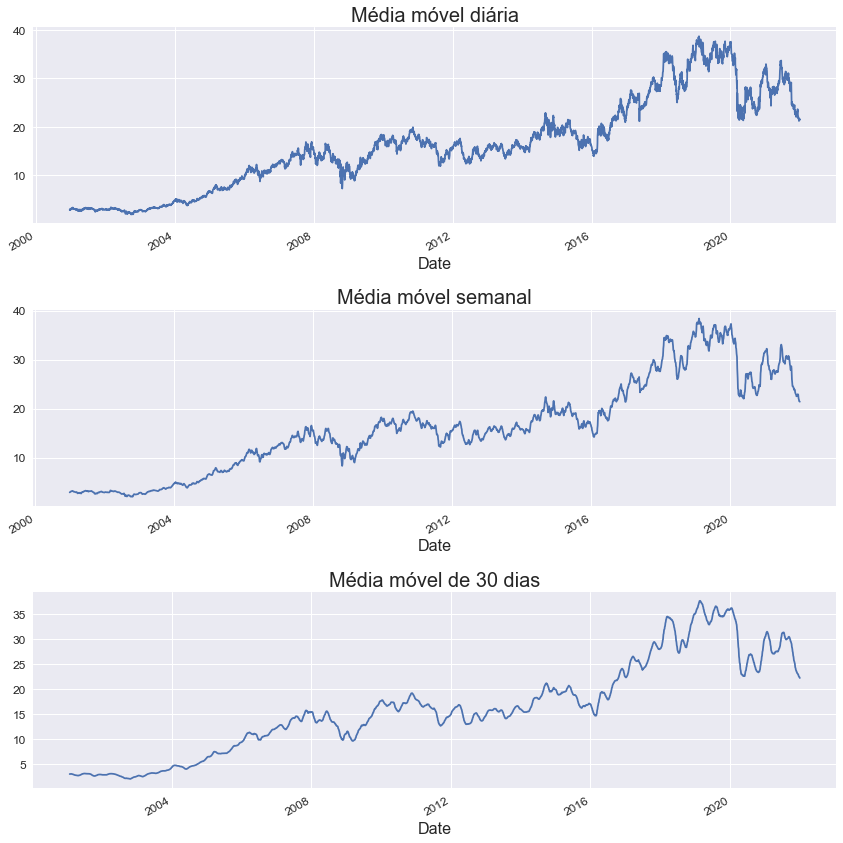

In [10]:
fig,ax=plt.subplots(nrows=3,ncols=1,figsize=(12,12))
stock.rolling(window=1).mean().plot(ax=ax[0])
stock.rolling(window=7).mean().plot(ax=ax[1])
stock.rolling(window=30).mean().plot(ax=ax[2])
ax[0].set_title('Média móvel diária',fontsize=20)
ax[1].set_title('Média móvel semanal',fontsize=20)
ax[2].set_title('Média móvel de 30 dias',fontsize=20)
plt.tight_layout()

 ### Fazendo predições
Vamos tentar ver como os valores das ações serão no futuro por meio de um modelo linear antes de construir nosso modelo real. Usaremos a biblioteca fbprophet para prever o preço futuro das ações para todo o ano de 2022.

In [11]:
data_train=stock.reset_index()
data_train.columns=['ds','y']

In [12]:
model=Prophet()
model.fit(data_train)

future=model.make_future_dataframe(periods=365)
predict=model.predict(future)

23:10:08 - cmdstanpy - INFO - Chain [1] start processing
23:10:11 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 46.5, 'Ano')

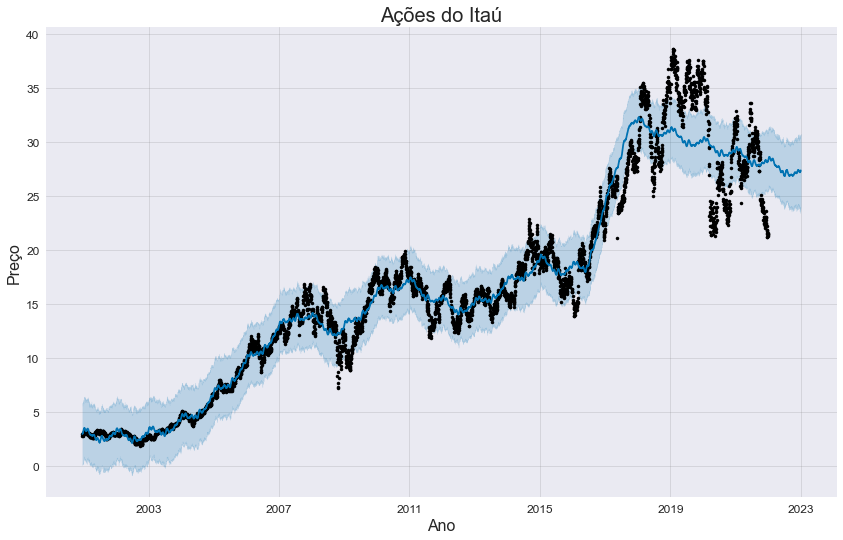

In [13]:
fig1=model.plot(predict,figsize=(12,7.5))
plt.title('Ações do Itaú',fontsize=20)
plt.ylabel('Preço')
plt.xlabel('Ano')

Text(0.5, 46.5, 'Ano')

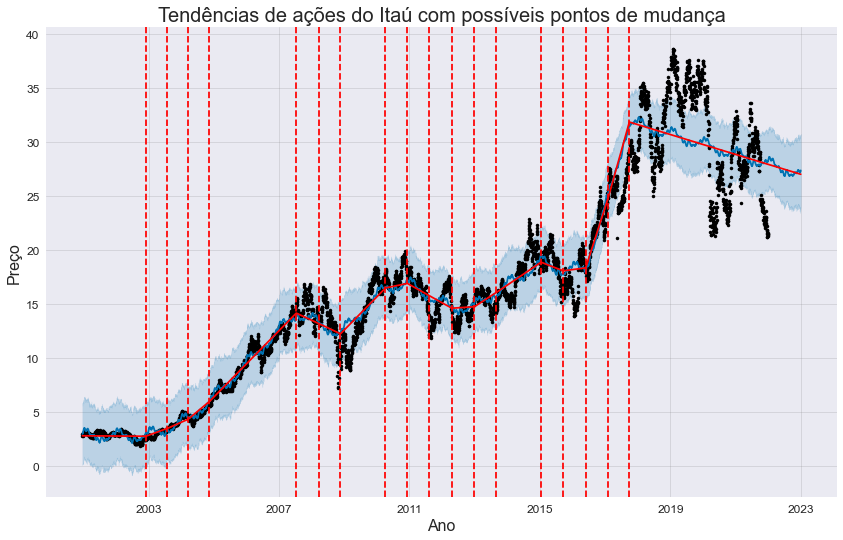

In [14]:
fig = model.plot(predict,figsize=(12,7.5))
a = add_changepoints_to_plot(fig.gca(), model, predict)
plt.title('Tendências de ações do Itaú com possíveis pontos de mudança',fontsize=20)
plt.ylabel('Preço')
plt.xlabel('Ano')

### Algumas tendências do papel

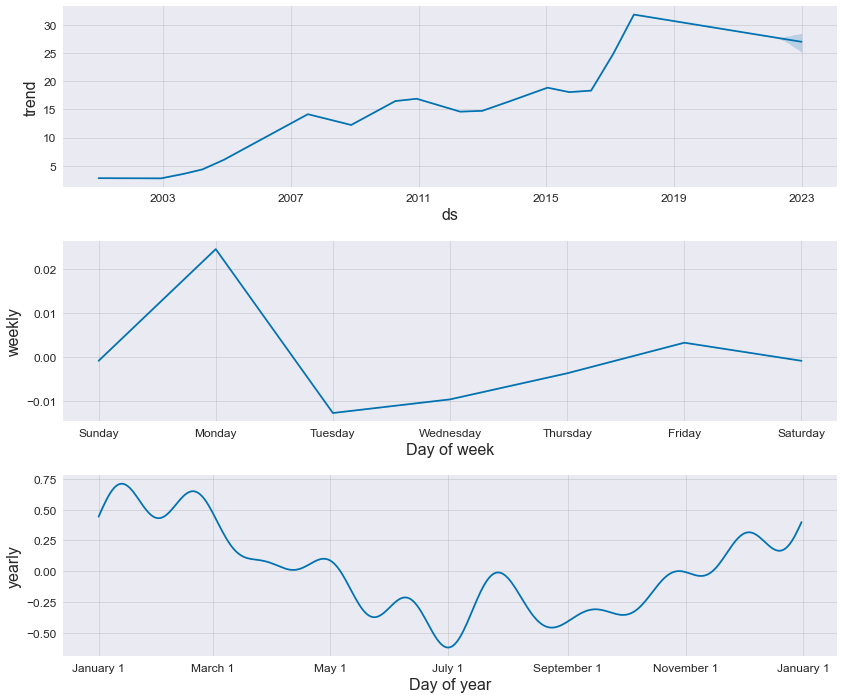

In [15]:
fig2=model.plot_components(predict,figsize=(12,10))

### Construindo um modelo RNN

Agora vamos construir nosso modelo para prever o preço das ações do Itaú. A ideia é treinar o modelo para prever as ações do dia seguinte com base nos preços das ações dos últimos 2 meses.

### Data Preprocessing

In [16]:
training_dataset=stock_past
training_data=training_dataset.iloc[:,1:2].values


sc=MinMaxScaler(feature_range=(0,1))  ##Normalização
training_data=sc.fit_transform(training_data)

#Scaling

X_train=[]
y_train=[]
for i in range(60,len(training_data)):
    X_train.append(training_data[i-60:i,0])
    y_train.append(training_data[i,0])

X_train= np.array(X_train)
y_train=np.array(y_train)    

X_train=X_train.reshape((len(training_data)-60),60,1)

### Construindo o modelo

In [34]:
regressor= Sequential()

#Camadas LSTM

regressor.add(LSTM(units=100,return_sequences=True,input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0,3))

regressor.add(LSTM(units=150,return_sequences=False))
regressor.add(Dropout(0,3))

regressor.add(Dense(units=10))

regressor.add(Dense(units=1))

regressor.compile(optimizer='adam',loss='mean_squared_error')

In [35]:
history = regressor.fit(X_train,y_train,epochs=10,batch_size=3,validation_split=0.1)

Epoch 1/10
1565/1565 [==============================] - 60s 36ms/step - loss: 7.3774e-04 - val_loss: 6.1341e-04
Epoch 2/10
1565/1565 [==============================] - 65s 42ms/step - loss: 2.5101e-04 - val_loss: 6.0255e-04
Epoch 3/10
1565/1565 [==============================] - 76s 49ms/step - loss: 1.7171e-04 - val_loss: 4.1438e-04
Epoch 4/10
1565/1565 [==============================] - 72s 46ms/step - loss: 2.0970e-04 - val_loss: 3.1203e-04
Epoch 5/10
1565/1565 [==============================] - 69s 44ms/step - loss: 1.6107e-04 - val_loss: 3.4013e-04
Epoch 6/10
1565/1565 [==============================] - 66s 42ms/step - loss: 1.4849e-04 - val_loss: 3.3708e-04
Epoch 7/10
1565/1565 [==============================] - 68s 44ms/step - loss: 1.4033e-04 - val_loss: 3.0833e-04
Epoch 8/10
1565/1565 [==============================] - 67s 43ms/step - loss: 1.2012e-04 - val_loss: 3.8631e-04
Epoch 9/10
1565/1565 [==============================] - 69s 44ms/step - loss: 1.2578e-04 - val_loss: 3.1

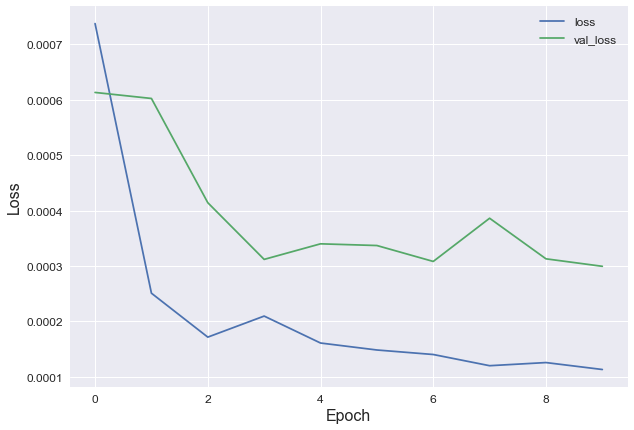

In [36]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

### Prevendo os valores das ações em 2022

In [37]:
#Obtendo os preços reais das ações em 2022 via API
test_dataset=pd.DataFrame(yf.download("ITUB4.SA", start="2022-01-01"))
real_stock_prices=test_dataset.iloc[:,1:2].values

[*********************100%***********************]  1 of 1 completed


### Regressão linear para 2022

In [38]:
predict_2022=predict[(predict['ds']>='2022-01-01') & (predict['ds']<'2023-01-01')][['ds','trend']] 
predict_2022=predict_2022.set_index('ds',drop=True)

Xt=pd.DataFrame(test_dataset)
new=Xt.join(predict_2022)
linear_prediction=new['trend'].values.reshape(len(new),1)

### Pré-processamento e predição dos dados de teste

In [39]:
total_dataset=pd.concat((training_dataset['Open'],test_dataset['Open']),axis=0)
inputs=total_dataset.iloc[len(total_dataset)-len(test_dataset)-60:].values
inputs=inputs.reshape(-1,1)

inputs=sc.transform(inputs)

X_test=[]
for i in range(60,(60+len(real_stock_prices))):
    X_test.append(inputs[i-60:i,0])
    
X_test= np.array(X_test)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

predicted_stock_values=regressor.predict(X_test)
predicted_stock_values=sc.inverse_transform(predicted_stock_values)

8/8 [==============================] - 1s 31ms/step


### Visualizando as previsões

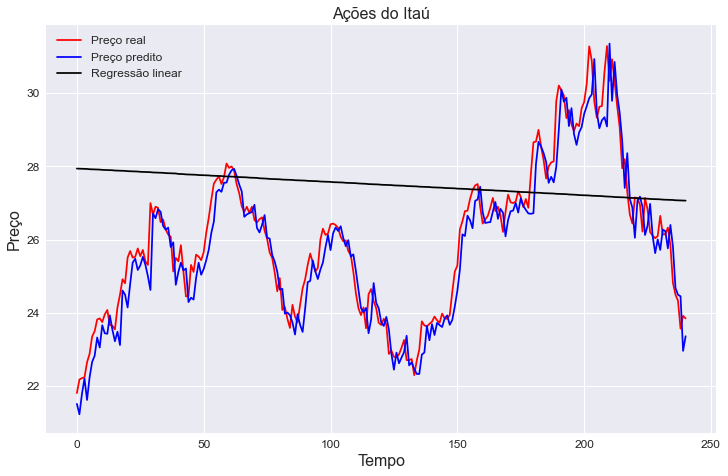

In [40]:
plt.figure(figsize=(12,7.5))
plt.plot(real_stock_prices,color='red',label='Preço real')
plt.plot(predicted_stock_values,color='blue',label='Preço predito')
plt.plot(linear_prediction,color='black',label='Regressão linear')
plt.title('Ações do Itaú')
plt.legend()
plt.xlabel('Tempo')
plt.ylabel('Preço')
plt.show()

O modelo previu as tendências muito melhor do que o modelo linear e melhor capaz de capturar a tendência direcional ao longo do tempo.

## Obrigado!